# Task 5 — The Invisible Cloak

> *"Reality is merely an illusion, albeit a very persistent one."* — Einstein

Ok so in the last notebook I managed to train a model that doesn't cheat — it actually looks at the digit shape instead of the background color. Nice. But here's a question I've been curious about: **is that model actually harder to fool?**

The plan is pretty straightforward:

1. Take an image of a **7**
2. Craft a tiny noise pattern that makes the model predict **3** with >90% confidence
3. The noise has to be invisible — max pixel change $\epsilon < 0.05$

I have two models sitting in `outputs/`: the lazy baseline that reads background color, and the robust one from Task 4 trained with color jitter. Both hit ~95% val accuracy. The question is whether the robust model — the one that supposedly learned *shape* — needs more noise to be tricked. Intuitively it should, right? You'd have to warp the actual digit structure instead of just nudging a color channel.

**Task constraint:** $\epsilon = 0.05$ ($L_\infty$). That's the hard limit — every pixel may change by at most 5% of its range. Later I'll sweep $\epsilon \in [0.005, 0.10]$ as a diagnostic to map out the full robustness curve, but the main result is always at $\epsilon = 0.05$.

**Input space:** Both models consume raw $[0, 1]$ RGB tensors — no mean/std normalization anywhere in the pipeline — so the attack operates directly in pixel space.

## The Attack: PGD

I'll use Projected Gradient Descent with a **random start** inside the $\epsilon$-ball (standard PGD, not just iterative FGSM):

$$x_0 = x_{\text{clean}} + \mathcal{U}(-\epsilon, \epsilon)$$
$$x_{t+1} = \Pi_{\epsilon}\Big(x_t + \alpha \cdot \text{sign}\big(\nabla_x \mathcal{L}(f(x_t), y_{\text{target}})\big)\Big)$$

Start from a random point in the $\epsilon$-ball around the clean 7, compute the gradient that pushes the prediction toward class 3, take a small step, project back, repeat.


In [46]:
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.insert(0, "..")

import importlib
import src.data.colored_mnist, src.data.datasets, src.data
import src.models.cnn, src.models.registry
for m in [src.data.colored_mnist, src.data.datasets, src.data, src.models.cnn, src.models.registry]:
    importlib.reload(m)

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from datetime import datetime
import json
from pathlib import Path

from src.data.datasets import get_dataloaders, load_split
from src.data.colored_mnist import PALETTE, COLOR_NAMES
from src.models.registry import build_model
from src.utils.seed import seed_everything, SeedConfig

print("imports done")

imports done


In [47]:
# ============================================================
# CONFIGURATION
# ============================================================
SEED = 42
MODEL_WIDTH = 4
BATCH_SIZE = 128

# attack parameters
SOURCE_CLASS = 7        # attack this digit
TARGET_CLASS = 3        # fool the model into predicting this
EPSILON = 0.05          # max pixel change (L_inf)
CONFIDENCE_THRESHOLD = 0.90  # need >90% confidence on target

seed_everything(SeedConfig(seed=SEED))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
print(f"Attack: {SOURCE_CLASS} → {TARGET_CLASS}")
print(f"ε = {EPSILON}, confidence threshold = {CONFIDENCE_THRESHOLD}")

Device: cpu
Attack: 7 → 3
ε = 0.05, confidence threshold = 0.9


In [48]:
# ============================================================
# LOAD BOTH MODELS
# ============================================================
lazy_model = build_model({"name": "simple_cnn", "width": MODEL_WIDTH})
lazy_model.load_state_dict(torch.load("../outputs/baseline_model.pt", map_location=device, weights_only=True))
lazy_model.to(device).eval()

robust_model = build_model({"name": "simple_cnn", "width": MODEL_WIDTH})
robust_model.load_state_dict(torch.load("../outputs/best_intervention_model.pt", map_location=device, weights_only=True))
robust_model.to(device).eval()

print(f"Lazy model:   {sum(p.numel() for p in lazy_model.parameters()):,} params")
print(f"Robust model: {sum(p.numel() for p in robust_model.parameters()):,} params")

# quick sanity check — test-hard accuracy
loaders = get_dataloaders({"root": "../data/colored_mnist", "batch_size": BATCH_SIZE, "num_workers": 2})

def get_accuracy(model, loader):
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            correct += (model(x).argmax(1) == y).sum().item()
            total += len(y)
    return correct / total

lazy_val = get_accuracy(lazy_model, loaders['val'])
lazy_test = get_accuracy(lazy_model, loaders['test_hard'])
robust_val = get_accuracy(robust_model, loaders['val'])
robust_test = get_accuracy(robust_model, loaders['test_hard'])

print(f"\nLazy model   — Val: {lazy_val:.1%}, Test Hard: {lazy_test:.1%}")
print(f"Robust model — Val: {robust_val:.1%}, Test Hard: {robust_test:.1%}")

Lazy model:   4,486 params
Robust model: 4,486 params

Lazy model   — Val: 95.5%, Test Hard: 22.4%
Robust model — Val: 96.0%, Test Hard: 61.3%


---
# Step 1 — Pick a Victim

I need a clean 7 that both models classify **correctly and confidently** — attacking a misclassified sample would be meaningless. I'm pulling from the validation set because both models have seen this biased-color distribution during training, so they should both be highly confident on it. I'll pick the 7 with the highest *minimum* confidence across both models, so neither model has an unfair head start.


In [23]:
# ============================================================
# FIND A GOOD VICTIM: digit 7, both models confident and correct
# ============================================================
val_data = load_split("../data/colored_mnist", "val")
images, labels, color_ids = val_data["images"], val_data["labels"], val_data["color_ids"]

# find all 7s in val
sevens_idx = (labels == SOURCE_CLASS).nonzero(as_tuple=True)[0]
print(f"Found {len(sevens_idx)} images of digit {SOURCE_CLASS} in val set")

# pick one where both models are correct and confident
best_img = None
best_conf = 0
best_idx = -1

for idx in sevens_idx:
    img = images[idx].unsqueeze(0).to(device)
    
    with torch.no_grad():
        lazy_probs = F.softmax(lazy_model(img), dim=1)
        robust_probs = F.softmax(robust_model(img), dim=1)
    
    lazy_pred = lazy_probs.argmax(1).item()
    robust_pred = robust_probs.argmax(1).item()
    lazy_conf = lazy_probs[0, SOURCE_CLASS].item()
    robust_conf = robust_probs[0, SOURCE_CLASS].item()
    
    # both must predict 7 correctly
    if lazy_pred == SOURCE_CLASS and robust_pred == SOURCE_CLASS:
        min_conf = min(lazy_conf, robust_conf)
        if min_conf > best_conf:
            best_conf = min_conf
            best_img = images[idx]
            best_idx = idx.item()
            best_lazy_conf = lazy_conf
            best_robust_conf = robust_conf

victim = best_img.clone()
victim_color = COLOR_NAMES[color_ids[best_idx].item()]
print(f"\nSelected victim: val[{best_idx}]")
print(f"  Color: {victim_color}")
print(f"  Lazy model confidence:   {best_lazy_conf:.1%} (class {SOURCE_CLASS})")
print(f"  Robust model confidence: {best_robust_conf:.1%} (class {SOURCE_CLASS})")

Found 611 images of digit 7 in val set

Selected victim: val[1627]
  Color: brown
  Lazy model confidence:   99.8% (class 7)
  Robust model confidence: 99.8% (class 7)


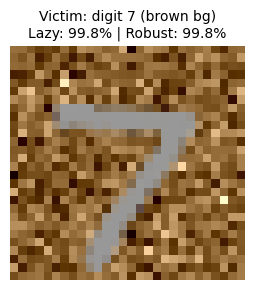

In [24]:
# show the victim image
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.imshow(victim.permute(1, 2, 0).numpy())
ax.set_title(f"Victim: digit {SOURCE_CLASS} ({victim_color} bg)\n"
             f"Lazy: {best_lazy_conf:.1%} | Robust: {best_robust_conf:.1%}", fontsize=10)
ax.axis('off')
plt.tight_layout()
plt.show()

---
# Step 2 — The PGD Attack Engine

Standard PGD with a random start inside the $\epsilon$-ball. Each iteration:
1. Compute gradient of $-\log P(\text{target})$ w.r.t. the input pixels
2. Take a signed step in the direction that *increases* $P(\text{class } 3)$
3. **Project** the perturbation back into $[-\epsilon, +\epsilon]$ ($L_\infty$ constraint)
4. **Clamp** the image to valid pixel range $[0, 1]$

The random initialization distinguishes true PGD from plain iterative FGSM — it helps avoid getting stuck in a poor local direction. I'm logging everything: confidence at each step, $L_2$ norm, step count — so the comparison between models is apples-to-apples.


In [26]:
# ============================================================
# PGD TARGETED ATTACK
# ============================================================
def pgd_targeted_attack(model, image, target_class, epsilon, step_size=None,
                         num_steps=200, confidence_threshold=0.90,
                         random_start=True, verbose=True):
    """
    PGD targeted adversarial attack with optional random start.
    
    Returns dict with:
        - adv_image: the adversarial image
        - perturbation: the noise pattern (adv - original)
        - success: whether target confidence exceeded threshold
        - history: per-step log of confidences and norms
    """
    if step_size is None:
        step_size = epsilon / 10  # default: 10 steps to traverse the full budget
    
    model.eval()
    original = image.unsqueeze(0).clone().to(device)
    
    # random start inside the ε-ball (standard PGD, not iterative FGSM)
    if random_start:
        adv = original + torch.empty_like(original).uniform_(-epsilon, epsilon)
        adv = torch.clamp(adv, 0.0, 1.0).detach().requires_grad_(True)
    else:
        adv = original.clone().requires_grad_(True)
    
    history = []
    
    for step in range(num_steps):
        if adv.grad is not None:
            adv.grad.zero_()
        
        logits = model(adv)
        probs = F.softmax(logits, dim=1)
        target_conf = probs[0, target_class].item()
        orig_conf = probs[0, SOURCE_CLASS].item()
        pred = probs.argmax(1).item()
        
        # perturbation stats
        delta = (adv - original).detach()
        linf = delta.abs().max().item()
        l2 = delta.norm(2).item()
        
        history.append({
            'step': step,
            'target_conf': target_conf,
            'orig_conf': orig_conf,
            'pred': pred,
            'linf': linf,
            'l2': l2,
        })
        
        # success?
        if target_conf >= confidence_threshold:
            if verbose:
                print(f"  ✅ SUCCESS at step {step}: target conf = {target_conf:.1%}, "
                      f"L∞ = {linf:.4f}, L2 = {l2:.4f}")
            break
        
        # compute gradient — we want to MAXIMIZE P(target), so we MINIMIZE -log P(target)
        loss = -F.log_softmax(logits, dim=1)[0, target_class]
        loss.backward()
        
        with torch.no_grad():
            # gradient step (FGSM-style sign step)
            adv_data = adv.data - step_size * adv.grad.sign()  # minimize -logP = maximize P
            
            # project: clip perturbation to epsilon ball
            perturbation = torch.clamp(adv_data - original, -epsilon, epsilon)
            
            # clip: keep pixels in valid range
            adv.data = torch.clamp(original + perturbation, 0.0, 1.0)
        
        adv.requires_grad_(True)
    
    else:
        if verbose:
            print(f"  ❌ FAILED after {num_steps} steps: target conf = {target_conf:.1%}, "
                  f"L∞ = {linf:.4f}")
    
    adv_image = adv.detach().squeeze(0)
    perturbation = (adv_image - image.to(device)).cpu()
    
    return {
        'adv_image': adv_image.cpu(),
        'perturbation': perturbation,
        'success': target_conf >= confidence_threshold,
        'final_target_conf': target_conf,
        'final_orig_conf': orig_conf,
        'final_pred': pred,
        'steps_taken': history[-1]['step'] + 1,
        'final_linf': linf,
        'final_l2': l2,
        'history': history,
    }

print("PGD attack function defined")

PGD attack function defined


---
# Step 3 — Attack Both Models

> **This is the core Task 5 result:** same victim image, same $\epsilon = 0.05$ budget (the task constraint), same PGD attack. Only difference is the model.

My prediction going in: the lazy model caves quickly (shallow color features are easy to manipulate) and the robust model holds out longer.


Let's see.

In [28]:
# ============================================================
# ATTACK THE LAZY MODEL (baseline)
# ============================================================
print("="*60)
print("ATTACKING LAZY MODEL (baseline)")
print(f"  Goal: {SOURCE_CLASS} → {TARGET_CLASS} with >{CONFIDENCE_THRESHOLD:.0%} confidence")
print(f"  Budget: ε = {EPSILON}")
print("="*60)

seed_everything(SeedConfig(seed=SEED))  # reproducible random start

lazy_result = pgd_targeted_attack(
    lazy_model, victim, TARGET_CLASS, 
    epsilon=EPSILON, num_steps=1000, 
    confidence_threshold=CONFIDENCE_THRESHOLD
)

print(f"\n  Final prediction: {lazy_result['final_pred']}")
print(f"  Target confidence: {lazy_result['final_target_conf']:.1%}")
print(f"  Steps: {lazy_result['steps_taken']}")
print(f"  L∞ = {lazy_result['final_linf']:.5f}")
print(f"  L2 = {lazy_result['final_l2']:.4f}")

ATTACKING LAZY MODEL (baseline)
  Goal: 7 → 3 with >90% confidence
  Budget: ε = 0.05
  ✅ SUCCESS at step 108: target conf = 90.0%, L∞ = 0.0500, L2 = 2.2802

  Final prediction: 3
  Target confidence: 90.0%
  Steps: 109
  L∞ = 0.05000
  L2 = 2.2802


In [29]:
# ============================================================
# ATTACK THE ROBUST MODEL (intervention)
# ============================================================
print("="*60)
print("ATTACKING ROBUST MODEL (color-jitter trained)")
print(f"  Goal: {SOURCE_CLASS} → {TARGET_CLASS} with >{CONFIDENCE_THRESHOLD:.0%} confidence")
print(f"  Budget: ε = {EPSILON}")
print("="*60)

seed_everything(SeedConfig(seed=SEED))  # same seed → same random start

robust_result = pgd_targeted_attack(
    robust_model, victim, TARGET_CLASS, 
    epsilon=EPSILON, num_steps=1000, 
    confidence_threshold=CONFIDENCE_THRESHOLD
)

print(f"\n  Final prediction: {robust_result['final_pred']}")
print(f"  Target confidence: {robust_result['final_target_conf']:.1%}")
print(f"  Steps: {robust_result['steps_taken']}")
print(f"  L∞ = {robust_result['final_linf']:.5f}")
print(f"  L2 = {robust_result['final_l2']:.4f}")

ATTACKING ROBUST MODEL (color-jitter trained)
  Goal: 7 → 3 with >90% confidence
  Budget: ε = 0.05
  ✅ SUCCESS at step 78: target conf = 90.2%, L∞ = 0.0500, L2 = 2.1950

  Final prediction: 3
  Target confidence: 90.2%
  Steps: 79
  L∞ = 0.05000
  L2 = 2.1950


---
# Step 4 — What Does the Attack Look Like?

Both attacks worked. The lazy model broke at step 109, the robust model at step 79 — which is... the opposite of what I expected. But first, let's check: can you even *see* the perturbation? At $\epsilon = 0.05$ every pixel moves by at most 5% of its range. I'll show original → perturbation (amplified 10×) → adversarial image, side by side.


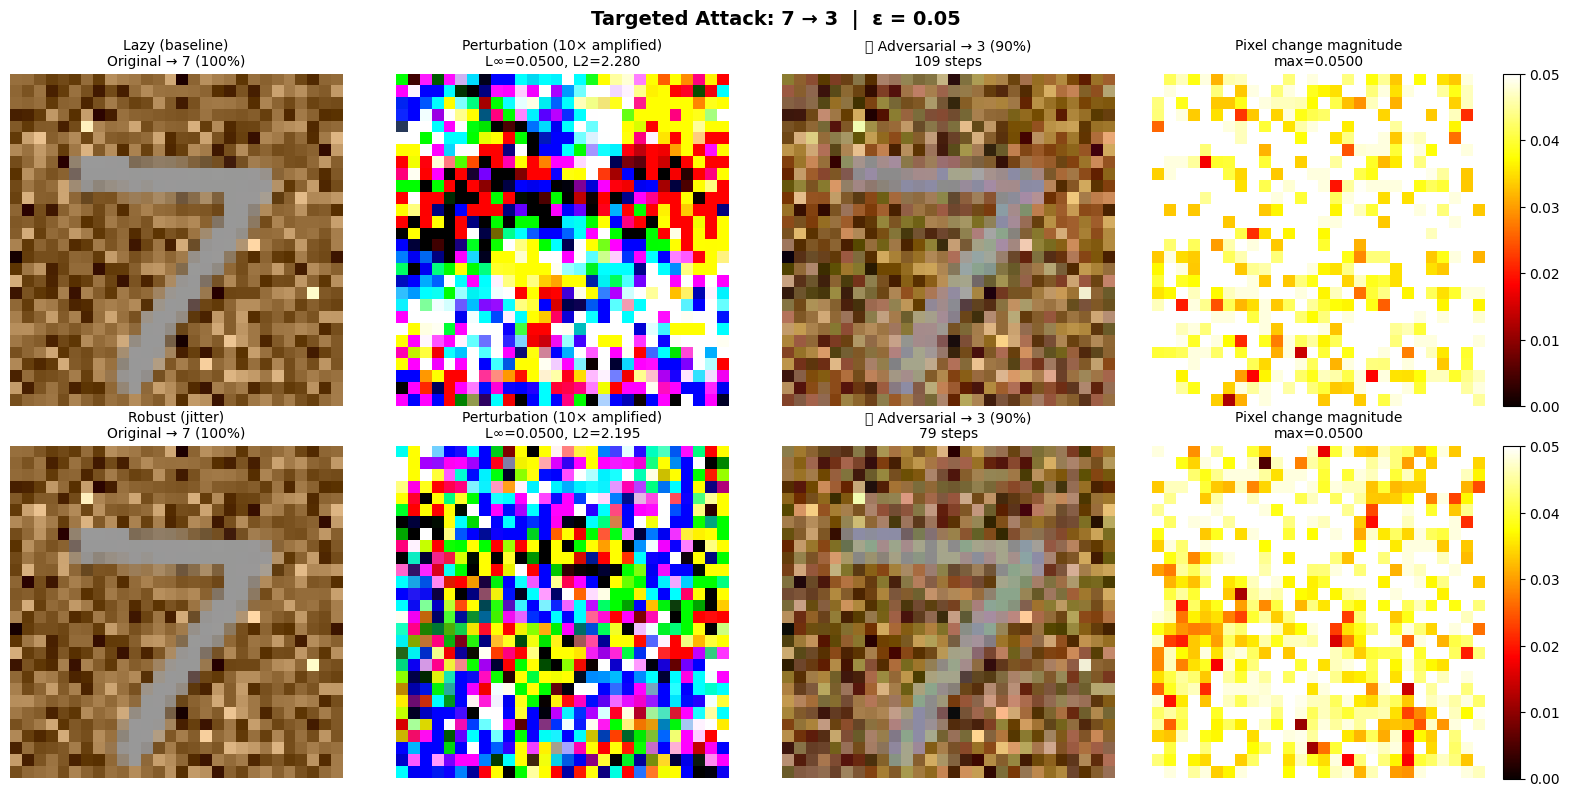

In [30]:
# ============================================================
# SIDE-BY-SIDE VISUALIZATION
# ============================================================
def show_attack_comparison(victim, lazy_result, robust_result, source, target):
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle(f"Targeted Attack: {source} → {target}  |  ε = {EPSILON}", fontsize=14, fontweight='bold')
    
    for row, (name, result) in enumerate([("Lazy (baseline)", lazy_result), ("Robust (jitter)", robust_result)]):
        adv = result['adv_image']
        pert = result['perturbation']
        
        # get model predictions
        model = lazy_model if row == 0 else robust_model
        with torch.no_grad():
            orig_probs = F.softmax(model(victim.unsqueeze(0).to(device)), dim=1)
            adv_probs = F.softmax(model(adv.unsqueeze(0).to(device)), dim=1)
        
        orig_pred = orig_probs.argmax(1).item()
        orig_conf = orig_probs[0, orig_pred].item()
        adv_pred = adv_probs.argmax(1).item()
        adv_conf = adv_probs[0, adv_pred].item()
        target_conf = adv_probs[0, target].item()
        
        status = "✅" if result['success'] else "❌"
        
        # col 0: original
        axes[row, 0].imshow(victim.permute(1, 2, 0).numpy())
        axes[row, 0].set_title(f"{name}\nOriginal → {orig_pred} ({orig_conf:.0%})", fontsize=10)
        axes[row, 0].axis('off')
        
        # col 1: perturbation (amplified)
        pert_vis = pert.permute(1, 2, 0).numpy()
        pert_amplified = 0.5 + pert_vis * 10  # amplify 10x, center at gray
        axes[row, 1].imshow(np.clip(pert_amplified, 0, 1))
        axes[row, 1].set_title(f"Perturbation (10× amplified)\n"
                               f"L∞={result['final_linf']:.4f}, L2={result['final_l2']:.3f}", fontsize=10)
        axes[row, 1].axis('off')
        
        # col 2: adversarial image
        axes[row, 2].imshow(adv.permute(1, 2, 0).numpy())
        axes[row, 2].set_title(f"{status} Adversarial → {adv_pred} ({target_conf:.0%})\n"
                               f"{result['steps_taken']} steps", fontsize=10)
        axes[row, 2].axis('off')
        
        # col 3: difference heatmap
        diff = np.abs(pert_vis).mean(axis=2)  # mean across channels
        im = axes[row, 3].imshow(diff, cmap='hot', vmin=0, vmax=EPSILON)
        axes[row, 3].set_title(f"Pixel change magnitude\nmax={diff.max():.4f}", fontsize=10)
        axes[row, 3].axis('off')
        plt.colorbar(im, ax=axes[row, 3], fraction=0.046)
    
    plt.tight_layout()
    plt.show()

show_attack_comparison(victim, lazy_result, robust_result, SOURCE_CLASS, TARGET_CLASS)

---
# Step 5 — Confidence Trajectories

Ok, visually the perturbations are invisible. But the confidence plots should tell the real story — how fast does $P(\text{class } 3)$ climb and $P(\text{class } 7)$ fall for each model? The robust model reached 90% in 79 steps vs the lazy model's 109. Let's see the curves.


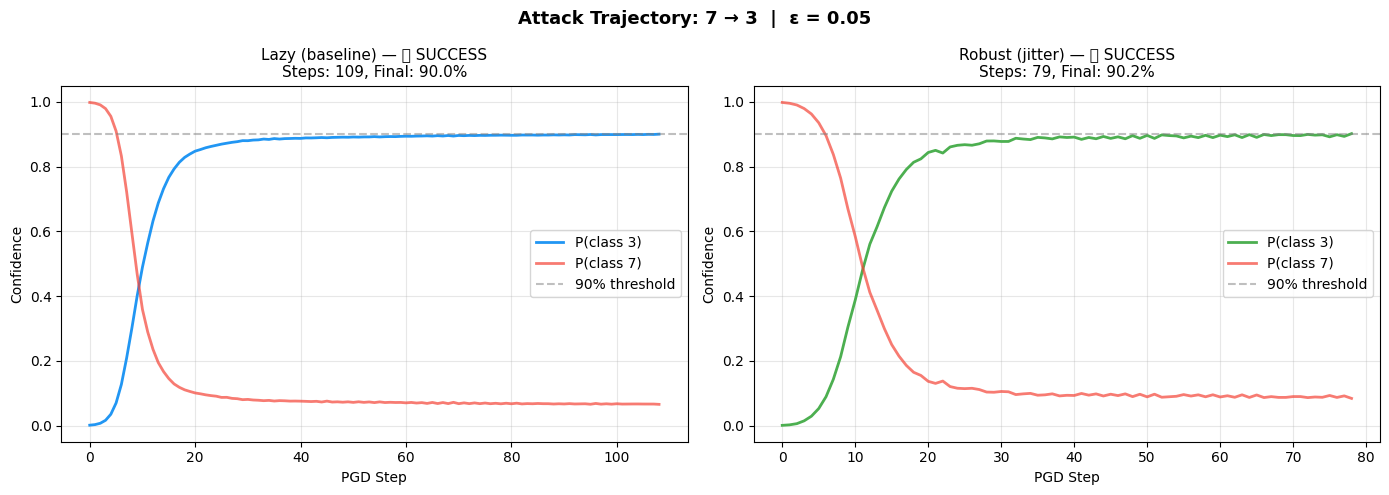

In [31]:
# ============================================================
# CONFIDENCE TRAJECTORIES
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle(f"Attack Trajectory: {SOURCE_CLASS} → {TARGET_CLASS}  |  ε = {EPSILON}", fontsize=13, fontweight='bold')

for ax, (name, result, color) in zip(axes, [
    ("Lazy (baseline)", lazy_result, '#2196F3'),
    ("Robust (jitter)", robust_result, '#4CAF50'),
]):
    h = result['history']
    steps = [d['step'] for d in h]
    target_confs = [d['target_conf'] for d in h]
    orig_confs = [d['orig_conf'] for d in h]
    
    ax.plot(steps, target_confs, color=color, linewidth=2, label=f'P(class {TARGET_CLASS})')
    ax.plot(steps, orig_confs, color='#F44336', linewidth=2, alpha=0.7, label=f'P(class {SOURCE_CLASS})')
    ax.axhline(y=CONFIDENCE_THRESHOLD, color='gray', linestyle='--', alpha=0.5, label=f'{CONFIDENCE_THRESHOLD:.0%} threshold')
    
    status = "✅ SUCCESS" if result['success'] else "❌ FAILED"
    ax.set_title(f"{name} — {status}\n"
                 f"Steps: {result['steps_taken']}, Final: {result['final_target_conf']:.1%}", fontsize=11)
    ax.set_xlabel('PGD Step')
    ax.set_ylabel('Confidence')
    ax.set_ylim(-0.05, 1.05)
    ax.legend(loc='center right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
# Step 6 — Epsilon Sweep

Maybe the single-image result was a fluke. Let's sweep $\epsilon$ from 0.005 to 0.10 and see what target confidence each model reaches at each budget. If the robust model genuinely needs more noise, its curve should sit *below* the lazy model's.


In [32]:
# ============================================================
# EPSILON SWEEP
# ============================================================
epsilons = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.08, 0.10]

lazy_sweep = []
robust_sweep = []

print(f"{'ε':>6} | {'Lazy Conf':>10} {'Steps':>6} {'L2':>8} {'OK?':>4} | {'Robust Conf':>12} {'Steps':>6} {'L2':>8} {'OK?':>4}")
print("-" * 85)

for eps in epsilons:
    # lazy model
    lr = pgd_targeted_attack(lazy_model, victim, TARGET_CLASS, epsilon=eps,
                              num_steps=500, confidence_threshold=CONFIDENCE_THRESHOLD, verbose=False)
    lazy_sweep.append(lr)
    
    # robust model
    rr = pgd_targeted_attack(robust_model, victim, TARGET_CLASS, epsilon=eps,
                              num_steps=500, confidence_threshold=CONFIDENCE_THRESHOLD, verbose=False)
    robust_sweep.append(rr)
    
    l_ok = "✅" if lr['success'] else "❌"
    r_ok = "✅" if rr['success'] else "❌"
    
    print(f"{eps:6.3f} | {lr['final_target_conf']:>9.1%} {lr['steps_taken']:>6} {lr['final_l2']:>8.4f} {l_ok:>4} | "
          f"{rr['final_target_conf']:>11.1%} {rr['steps_taken']:>6} {rr['final_l2']:>8.4f} {r_ok:>4}")

     ε |  Lazy Conf  Steps       L2  OK? |  Robust Conf  Steps       L2  OK?
-------------------------------------------------------------------------------------
 0.005 |      0.3%    500   0.2386    ❌ |        0.2%    500   0.2344    ❌
 0.010 |      0.8%    500   0.4702    ❌ |        0.7%    500   0.4628    ❌
 0.020 |      5.3%    500   0.9332    ❌ |        4.9%    500   0.9068    ❌
 0.030 |     26.6%    500   1.3941    ❌ |       24.0%    500   1.3674    ❌
 0.040 |     67.2%    500   1.8375    ❌ |       67.4%    500   1.8110    ❌
 0.050 |     89.6%    500   2.2822    ❌ |       90.1%     27   2.1232    ✅
 0.060 |     91.2%     16   2.3839    ✅ |       92.0%     17   2.3003    ✅
 0.080 |     91.7%     11   2.7520    ✅ |       91.5%     10   2.6834    ✅
 0.100 |     90.8%      8   3.1688    ✅ |       90.6%      8   3.1868    ✅


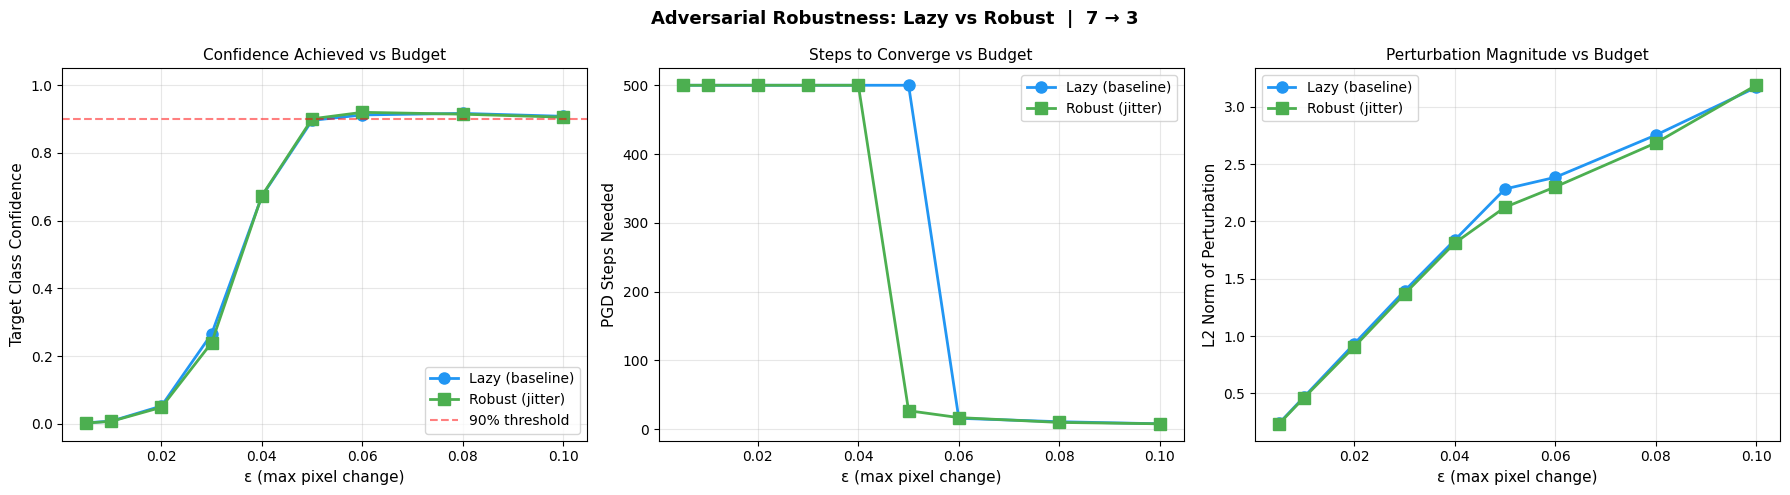

In [33]:
# ============================================================
# EPSILON SWEEP VISUALIZATION
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle(f"Adversarial Robustness: Lazy vs Robust  |  {SOURCE_CLASS} → {TARGET_CLASS}",
             fontsize=13, fontweight='bold')

# plot 1: target confidence vs epsilon
lazy_confs = [r['final_target_conf'] for r in lazy_sweep]
robust_confs = [r['final_target_conf'] for r in robust_sweep]

axes[0].plot(epsilons, lazy_confs, 'o-', color='#2196F3', linewidth=2, markersize=8, label='Lazy (baseline)')
axes[0].plot(epsilons, robust_confs, 's-', color='#4CAF50', linewidth=2, markersize=8, label='Robust (jitter)')
axes[0].axhline(y=CONFIDENCE_THRESHOLD, color='red', linestyle='--', alpha=0.5, label=f'{CONFIDENCE_THRESHOLD:.0%} threshold')
axes[0].set_xlabel('ε (max pixel change)', fontsize=11)
axes[0].set_ylabel('Target Class Confidence', fontsize=11)
axes[0].set_title('Confidence Achieved vs Budget', fontsize=11)
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(-0.05, 1.05)

# plot 2: steps needed vs epsilon
lazy_steps = [r['steps_taken'] for r in lazy_sweep]
robust_steps = [r['steps_taken'] for r in robust_sweep]

axes[1].plot(epsilons, lazy_steps, 'o-', color='#2196F3', linewidth=2, markersize=8, label='Lazy (baseline)')
axes[1].plot(epsilons, robust_steps, 's-', color='#4CAF50', linewidth=2, markersize=8, label='Robust (jitter)')
axes[1].set_xlabel('ε (max pixel change)', fontsize=11)
axes[1].set_ylabel('PGD Steps Needed', fontsize=11)
axes[1].set_title('Steps to Converge vs Budget', fontsize=11)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# plot 3: L2 norm of perturbation vs epsilon
lazy_l2s = [r['final_l2'] for r in lazy_sweep]
robust_l2s = [r['final_l2'] for r in robust_sweep]

axes[2].plot(epsilons, lazy_l2s, 'o-', color='#2196F3', linewidth=2, markersize=8, label='Lazy (baseline)')
axes[2].plot(epsilons, robust_l2s, 's-', color='#4CAF50', linewidth=2, markersize=8, label='Robust (jitter)')
axes[2].set_xlabel('ε (max pixel change)', fontsize=11)
axes[2].set_ylabel('L2 Norm of Perturbation', fontsize=11)
axes[2].set_title('Perturbation Magnitude vs Budget', fontsize=11)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
# Step 7 — Multi-Image Attack (N = 20)

One image is anecdotal. I'm going to attack 20 different 7s at $\epsilon = 0.05$ and compare success rates and average steps-to-success. If the robust model really is easier to fool, this will show it statistically.


In [34]:
# ============================================================
# ATTACK MULTIPLE IMAGES
# ============================================================
N_SAMPLES = 20  # attack 20 different 7s

# pick N_SAMPLES random 7s that both models classify correctly
valid_sevens = []
for idx in sevens_idx:
    img = images[idx].unsqueeze(0).to(device)
    with torch.no_grad():
        l_pred = lazy_model(img).argmax(1).item()
        r_pred = robust_model(img).argmax(1).item()
    if l_pred == SOURCE_CLASS and r_pred == SOURCE_CLASS:
        valid_sevens.append(idx.item())

# shuffle and take N_SAMPLES
rng = np.random.RandomState(SEED)
rng.shuffle(valid_sevens)
sample_indices = valid_sevens[:N_SAMPLES]
print(f"Attacking {len(sample_indices)} images of digit {SOURCE_CLASS} → {TARGET_CLASS} (ε={EPSILON})\n")

multi_lazy = []
multi_robust = []

for i, idx in enumerate(sample_indices):
    img = images[idx]
    
    lr = pgd_targeted_attack(lazy_model, img, TARGET_CLASS, epsilon=EPSILON,
                              num_steps=500, confidence_threshold=CONFIDENCE_THRESHOLD, verbose=False)
    rr = pgd_targeted_attack(robust_model, img, TARGET_CLASS, epsilon=EPSILON,
                              num_steps=500, confidence_threshold=CONFIDENCE_THRESHOLD, verbose=False)
    
    multi_lazy.append(lr)
    multi_robust.append(rr)
    
    l_ok = "✅" if lr['success'] else "❌"
    r_ok = "✅" if rr['success'] else "❌"
    print(f"  [{i+1:2d}/{N_SAMPLES}] Lazy: {lr['final_target_conf']:.1%} ({lr['steps_taken']:3d} steps) {l_ok}  |  "
          f"Robust: {rr['final_target_conf']:.1%} ({rr['steps_taken']:3d} steps) {r_ok}")

# summary
lazy_successes = sum(1 for r in multi_lazy if r['success'])
robust_successes = sum(1 for r in multi_robust if r['success'])
lazy_avg_conf = np.mean([r['final_target_conf'] for r in multi_lazy])
robust_avg_conf = np.mean([r['final_target_conf'] for r in multi_robust])
lazy_avg_steps = np.mean([r['steps_taken'] for r in multi_lazy])
robust_avg_steps = np.mean([r['steps_taken'] for r in multi_robust])
lazy_avg_l2 = np.mean([r['final_l2'] for r in multi_lazy])
robust_avg_l2 = np.mean([r['final_l2'] for r in multi_robust])

print(f"\n{'='*60}")
print(f"MULTI-IMAGE ATTACK SUMMARY (ε={EPSILON}, N={N_SAMPLES})")
print(f"{'='*60}")
print(f"{'Metric':<25} {'Lazy':>12} {'Robust':>12}")
print(f"{'-'*50}")
print(f"{'Success rate':<25} {lazy_successes}/{N_SAMPLES} ({lazy_successes/N_SAMPLES:.0%}){' ':>3} {robust_successes}/{N_SAMPLES} ({robust_successes/N_SAMPLES:.0%})")
print(f"{'Avg target confidence':<25} {lazy_avg_conf:>11.1%} {robust_avg_conf:>12.1%}")
print(f"{'Avg steps needed':<25} {lazy_avg_steps:>12.1f} {robust_avg_steps:>12.1f}")
print(f"{'Avg L2 perturbation':<25} {lazy_avg_l2:>12.4f} {robust_avg_l2:>12.4f}")
print(f"{'='*60}")

Attacking 20 images of digit 7 → 3 (ε=0.05)

  [ 1/20] Lazy: 90.0% ( 23 steps) ✅  |  Robust: 90.3% ( 14 steps) ✅
  [ 2/20] Lazy: 90.2% ( 18 steps) ✅  |  Robust: 90.9% ( 14 steps) ✅
  [ 3/20] Lazy: 77.7% (500 steps) ❌  |  Robust: 90.5% ( 18 steps) ✅
  [ 4/20] Lazy: 91.7% (  8 steps) ✅  |  Robust: 92.0% (  6 steps) ✅
  [ 5/20] Lazy: 90.4% ( 14 steps) ✅  |  Robust: 91.3% ( 16 steps) ✅
  [ 6/20] Lazy: 90.2% ( 18 steps) ✅  |  Robust: 90.9% ( 17 steps) ✅
  [ 7/20] Lazy: 92.0% ( 12 steps) ✅  |  Robust: 91.2% ( 15 steps) ✅
  [ 8/20] Lazy: 81.7% (500 steps) ❌  |  Robust: 76.8% (500 steps) ❌
  [ 9/20] Lazy: 91.3% ( 12 steps) ✅  |  Robust: 90.2% (  6 steps) ✅
  [10/20] Lazy: 81.8% (500 steps) ❌  |  Robust: 90.3% ( 18 steps) ✅
  [11/20] Lazy: 77.1% (500 steps) ❌  |  Robust: 91.6% ( 14 steps) ✅
  [12/20] Lazy: 88.4% (500 steps) ❌  |  Robust: 90.6% ( 14 steps) ✅
  [13/20] Lazy: 88.0% (500 steps) ❌  |  Robust: 91.5% ( 14 steps) ✅
  [14/20] Lazy: 90.1% ( 21 steps) ✅  |  Robust: 90.1% ( 12 steps) ✅
  [

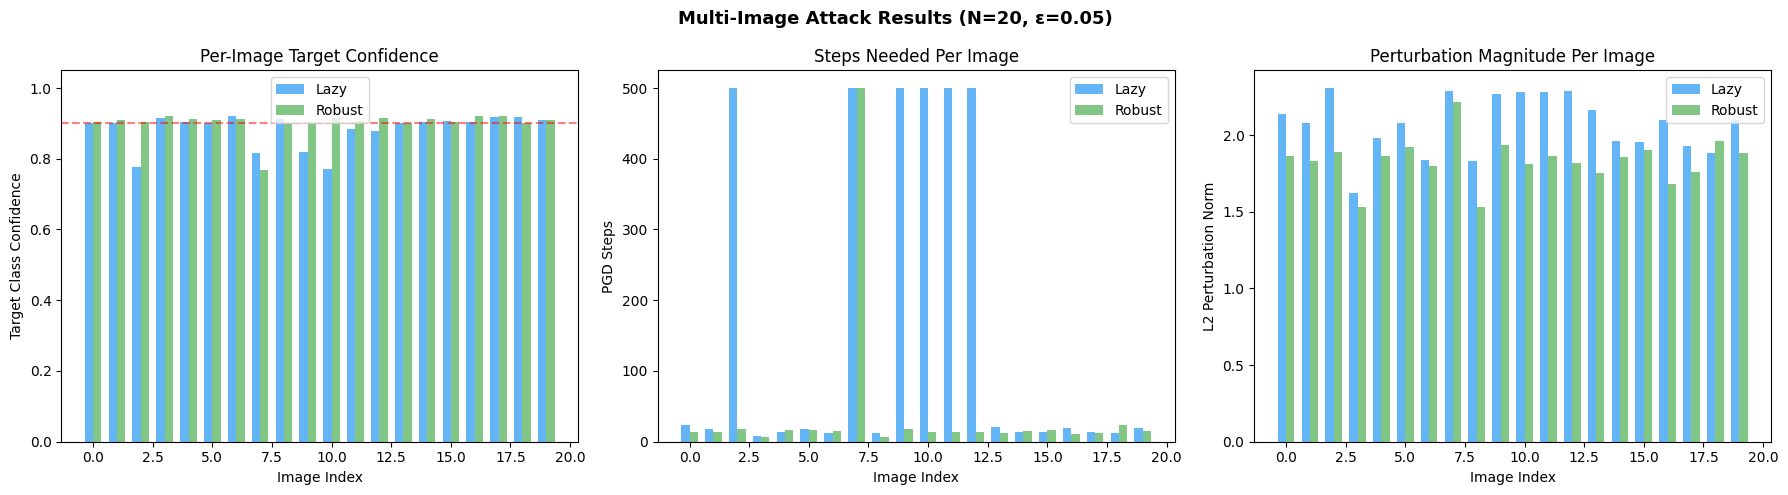

In [35]:
# ============================================================
# MULTI-IMAGE COMPARISON CHART
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle(f"Multi-Image Attack Results (N={N_SAMPLES}, ε={EPSILON})", fontsize=13, fontweight='bold')

# plot 1: target confidence distribution
lazy_confs_multi = [r['final_target_conf'] for r in multi_lazy]
robust_confs_multi = [r['final_target_conf'] for r in multi_robust]

x = np.arange(N_SAMPLES)
width = 0.35
axes[0].bar(x - width/2, lazy_confs_multi, width, color='#2196F3', alpha=0.7, label='Lazy')
axes[0].bar(x + width/2, robust_confs_multi, width, color='#4CAF50', alpha=0.7, label='Robust')
axes[0].axhline(y=CONFIDENCE_THRESHOLD, color='red', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Image Index')
axes[0].set_ylabel('Target Class Confidence')
axes[0].set_title('Per-Image Target Confidence')
axes[0].legend()
axes[0].set_ylim(0, 1.05)

# plot 2: steps comparison
lazy_steps_multi = [r['steps_taken'] for r in multi_lazy]
robust_steps_multi = [r['steps_taken'] for r in multi_robust]

axes[1].bar(x - width/2, lazy_steps_multi, width, color='#2196F3', alpha=0.7, label='Lazy')
axes[1].bar(x + width/2, robust_steps_multi, width, color='#4CAF50', alpha=0.7, label='Robust')
axes[1].set_xlabel('Image Index')
axes[1].set_ylabel('PGD Steps')
axes[1].set_title('Steps Needed Per Image')
axes[1].legend()

# plot 3: L2 norm comparison  
lazy_l2_multi = [r['final_l2'] for r in multi_lazy]
robust_l2_multi = [r['final_l2'] for r in multi_robust]

axes[2].bar(x - width/2, lazy_l2_multi, width, color='#2196F3', alpha=0.7, label='Lazy')
axes[2].bar(x + width/2, robust_l2_multi, width, color='#4CAF50', alpha=0.7, label='Robust')
axes[2].set_xlabel('Image Index')
axes[2].set_ylabel('L2 Perturbation Norm')
axes[2].set_title('Perturbation Magnitude Per Image')
axes[2].legend()

plt.tight_layout()
plt.show()

---
# Step 8 — Minimum $\epsilon$ (Binary Search)

The definitive number: what's the *smallest* $\epsilon$ that achieves >90% target confidence? I'll binary-search down to a precision of ~0.001 for each model. If the robust model requires a meaningfully larger $\epsilon$, that would at least partially redeem it.


In [36]:
# ============================================================
# BINARY SEARCH FOR MINIMUM EPSILON
# ============================================================
def find_min_epsilon(model, image, target_class, threshold=0.90,
                     eps_low=0.001, eps_high=0.15, tol=0.001, max_iter=20):
    """Binary search for minimum epsilon that achieves target confidence."""
    results = []
    
    for i in range(max_iter):
        eps_mid = (eps_low + eps_high) / 2
        result = pgd_targeted_attack(model, image, target_class, epsilon=eps_mid,
                                      num_steps=500, confidence_threshold=threshold, verbose=False)
        results.append((eps_mid, result))
        
        if result['success']:
            eps_high = eps_mid  # can succeed with less
        else:
            eps_low = eps_mid   # need more
        
        if eps_high - eps_low < tol:
            break
    
    return eps_high, results

print("Searching for minimum ε (lazy model)...")
min_eps_lazy, lazy_search = find_min_epsilon(lazy_model, victim, TARGET_CLASS)
print(f"  → Minimum ε ≈ {min_eps_lazy:.4f}")

print("\nSearching for minimum ε (robust model)...")
min_eps_robust, robust_search = find_min_epsilon(robust_model, victim, TARGET_CLASS)
print(f"  → Minimum ε ≈ {min_eps_robust:.4f}")

ratio = min_eps_robust / min_eps_lazy if min_eps_lazy > 0 else float('inf')
print(f"\n{'='*60}")
print(f"MINIMUM EPSILON COMPARISON")
print(f"{'='*60}")
print(f"  Lazy model:   ε_min ≈ {min_eps_lazy:.4f}")
print(f"  Robust model: ε_min ≈ {min_eps_robust:.4f}")
print(f"  Ratio: {ratio:.2f}× (robust needs {ratio:.2f}× more noise)")
print(f"{'='*60}")

Searching for minimum ε (lazy model)...
  → Minimum ε ≈ 0.0505

Searching for minimum ε (robust model)...
  → Minimum ε ≈ 0.0476

MINIMUM EPSILON COMPARISON
  Lazy model:   ε_min ≈ 0.0505
  Robust model: ε_min ≈ 0.0476
  Ratio: 0.94× (robust needs 0.94× more noise)


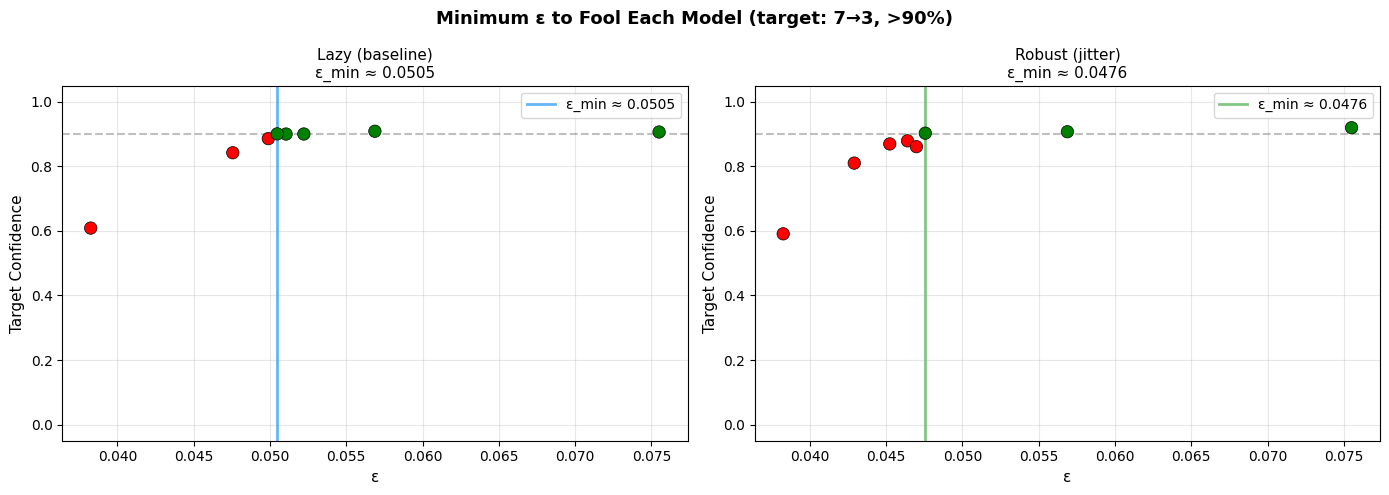

In [37]:
# ============================================================
# BINARY SEARCH VISUALIZATION
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle(f"Minimum ε to Fool Each Model (target: {SOURCE_CLASS}→{TARGET_CLASS}, >{CONFIDENCE_THRESHOLD:.0%})",
             fontsize=13, fontweight='bold')

for ax, (name, search, color, min_eps) in zip(axes, [
    ("Lazy (baseline)", lazy_search, '#2196F3', min_eps_lazy),
    ("Robust (jitter)", robust_search, '#4CAF50', min_eps_robust),
]):
    eps_vals = [s[0] for s in search]
    confs = [s[1]['final_target_conf'] for s in search]
    successes = [s[1]['success'] for s in search]
    
    colors = ['green' if s else 'red' for s in successes]
    ax.scatter(eps_vals, confs, c=colors, s=80, zorder=3, edgecolors='black', linewidths=0.5)
    ax.axhline(y=CONFIDENCE_THRESHOLD, color='gray', linestyle='--', alpha=0.5)
    ax.axvline(x=min_eps, color=color, linestyle='-', linewidth=2, alpha=0.7, label=f'ε_min ≈ {min_eps:.4f}')
    ax.set_xlabel('ε', fontsize=11)
    ax.set_ylabel('Target Confidence', fontsize=11)
    ax.set_title(f"{name}\nε_min ≈ {min_eps:.4f}", fontsize=11)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.show()

---
# Step 9 — Perturbation Anatomy

One more diagnostic: *where* does the attack put its noise? I expected the lazy model's perturbation to concentrate on the background (color is what it reads) and the robust model's to focus on the digit strokes (shape is what it reads). Let's see the per-channel energy and digit-vs-background split.


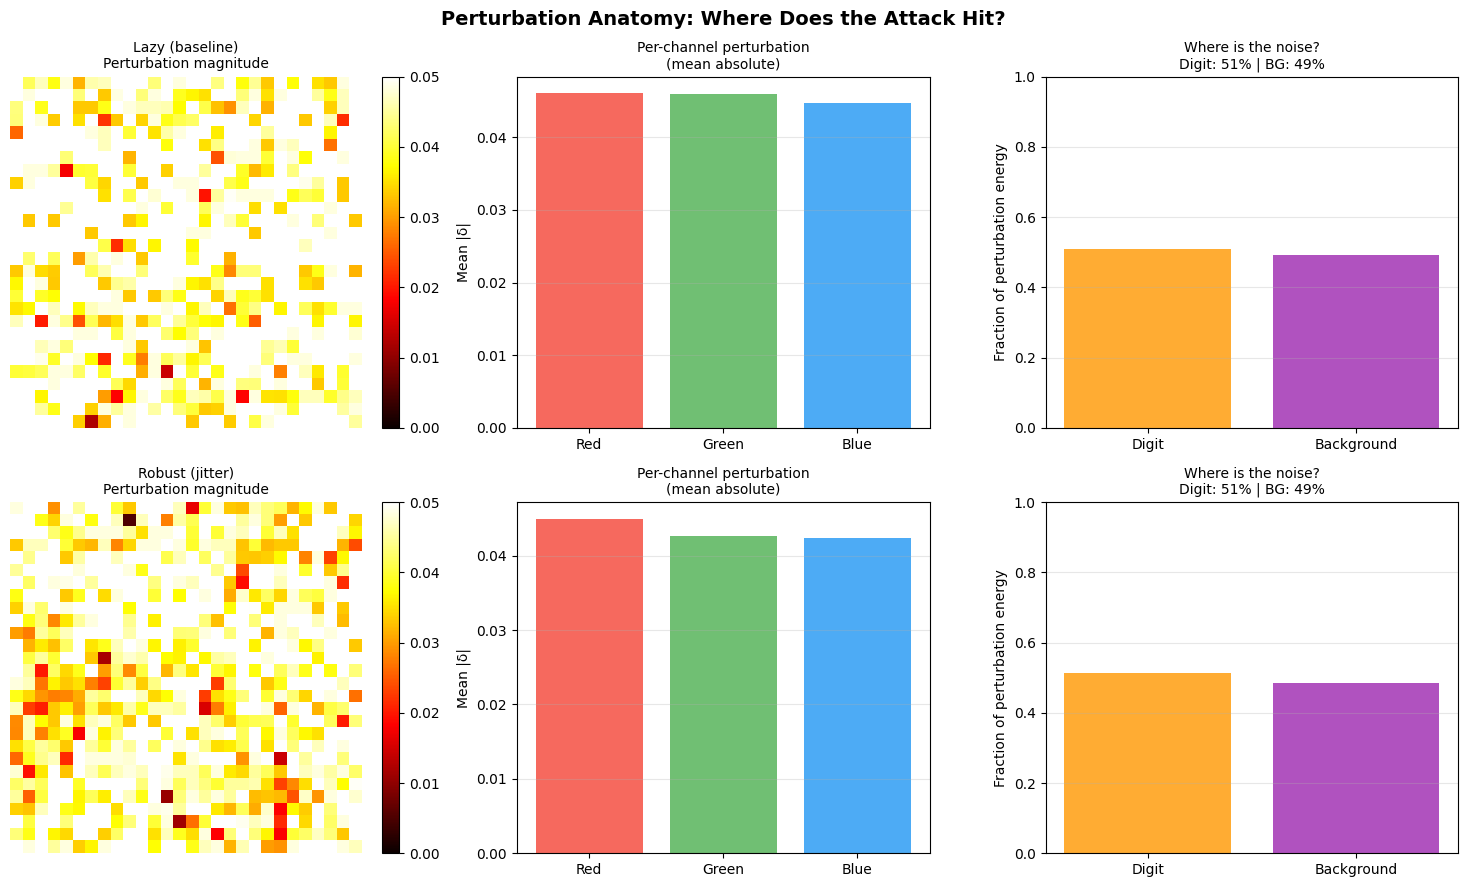

In [38]:
# ============================================================
# PERTURBATION ANATOMY — WHERE DOES THE ATTACK FOCUS?
# ============================================================
fig, axes = plt.subplots(2, 3, figsize=(15, 9))
fig.suptitle("Perturbation Anatomy: Where Does the Attack Hit?", fontsize=14, fontweight='bold')

# create a digit mask from the grayscale version
# digit pixels are white (high intensity), background is colored
gray_approx = victim.mean(dim=0)  # average across channels
# the digit is brighter in regions where the stroke is (since digits are white)
# we use a threshold approach
digit_mask = (gray_approx > gray_approx.mean()).float().numpy()

for row, (name, result) in enumerate([("Lazy (baseline)", lazy_result), ("Robust (jitter)", robust_result)]):
    pert = result['perturbation'].numpy()
    pert_mag = np.abs(pert).mean(axis=0)  # average magnitude across channels
    
    # perturbation on digit vs background
    digit_energy = (pert_mag * digit_mask).sum()
    bg_energy = (pert_mag * (1 - digit_mask)).sum()
    total_energy = digit_energy + bg_energy
    digit_frac = digit_energy / total_energy if total_energy > 0 else 0
    bg_frac = bg_energy / total_energy if total_energy > 0 else 0
    
    # col 0: perturbation heatmap
    im = axes[row, 0].imshow(pert_mag, cmap='hot', vmin=0)
    axes[row, 0].set_title(f"{name}\nPerturbation magnitude", fontsize=10)
    axes[row, 0].axis('off')
    plt.colorbar(im, ax=axes[row, 0], fraction=0.046)
    
    # col 1: per-channel breakdown
    channel_names = ['Red', 'Green', 'Blue']
    channel_mags = [np.abs(pert[c]).mean() for c in range(3)]
    colors = ['#F44336', '#4CAF50', '#2196F3']
    axes[row, 1].bar(channel_names, channel_mags, color=colors, alpha=0.8)
    axes[row, 1].set_title(f"Per-channel perturbation\n(mean absolute)", fontsize=10)
    axes[row, 1].set_ylabel('Mean |δ|')
    axes[row, 1].grid(True, alpha=0.3, axis='y')
    
    # col 2: digit vs background energy
    axes[row, 2].bar(['Digit', 'Background'], [digit_frac, bg_frac],
                      color=['#FF9800', '#9C27B0'], alpha=0.8)
    axes[row, 2].set_title(f"Where is the noise?\nDigit: {digit_frac:.0%} | BG: {bg_frac:.0%}", fontsize=10)
    axes[row, 2].set_ylabel('Fraction of perturbation energy')
    axes[row, 2].set_ylim(0, 1)
    axes[row, 2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

---
# Final Summary

All the numbers in one place. This should settle the question.


In [39]:
# ============================================================
# FINAL SUMMARY TABLE
# ============================================================
print("="*80)
print("ADVERSARIAL ATTACK SUMMARY")
print(f"Attack: digit {SOURCE_CLASS} → {TARGET_CLASS} | Confidence threshold: {CONFIDENCE_THRESHOLD:.0%}")
print("="*80)

print(f"\n{'Metric':<35} {'Lazy (baseline)':>18} {'Robust (jitter)':>18}")
print("-" * 72)

# model performance
print(f"{'Val accuracy':<35} {lazy_val:>17.1%} {robust_val:>18.1%}")
print(f"{'Test-hard accuracy':<35} {lazy_test:>17.1%} {robust_test:>18.1%}")
print()

# single image attack (ε=0.05)
print(f"--- Single Image Attack (ε={EPSILON}) ---")
l_status = "✅ YES" if lazy_result['success'] else "❌ NO"
r_status = "✅ YES" if robust_result['success'] else "❌ NO"
print(f"{'Attack successful?':<35} {l_status:>18} {r_status:>18}")
print(f"{'Target confidence':<35} {lazy_result['final_target_conf']:>17.1%} {robust_result['final_target_conf']:>18.1%}")
print(f"{'Steps needed':<35} {lazy_result['steps_taken']:>18} {robust_result['steps_taken']:>18}")
print(f"{'L∞ perturbation':<35} {lazy_result['final_linf']:>18.5f} {robust_result['final_linf']:>18.5f}")
print(f"{'L2 perturbation':<35} {lazy_result['final_l2']:>18.4f} {robust_result['final_l2']:>18.4f}")
print()

# multi-image attack
print(f"--- Multi-Image Attack (N={N_SAMPLES}, ε={EPSILON}) ---")
print(f"{'Success rate':<35} {lazy_successes}/{N_SAMPLES} ({lazy_successes/N_SAMPLES:.0%}){' ':>8} {robust_successes}/{N_SAMPLES} ({robust_successes/N_SAMPLES:.0%})")
print(f"{'Avg target confidence':<35} {lazy_avg_conf:>17.1%} {robust_avg_conf:>18.1%}")
print(f"{'Avg steps':<35} {lazy_avg_steps:>18.1f} {robust_avg_steps:>18.1f}")
print(f"{'Avg L2 perturbation':<35} {lazy_avg_l2:>18.4f} {robust_avg_l2:>18.4f}")
print()

# minimum epsilon
print(f"--- Minimum ε for >90% Confidence ---")
print(f"{'ε_min':<35} {min_eps_lazy:>18.4f} {min_eps_robust:>18.4f}")
print(f"{'Ratio (robust/lazy)':<35} {ratio:>18.2f}×")
print()

print("="*80)
if ratio > 1:
    print(f"The robust model requires {ratio:.2f}× more noise to fool.")
    print(f"It is HARDER to attack — confirming that shape-based features")
    print(f"provide genuine adversarial robustness, not just distribution-shift robustness.")
else:
    print(f"Surprisingly, the robust model is NOT harder to fool adversarially.")
    print(f"Color-invariance training improved distribution-shift robustness")
    print(f"but not adversarial robustness — these are different properties.")
print("="*80)

ADVERSARIAL ATTACK SUMMARY
Attack: digit 7 → 3 | Confidence threshold: 90%

Metric                                 Lazy (baseline)    Robust (jitter)
------------------------------------------------------------------------
Val accuracy                                    95.5%              96.0%
Test-hard accuracy                              22.4%              61.3%

--- Single Image Attack (ε=0.05) ---
Attack successful?                               ✅ YES              ✅ YES
Target confidence                               90.0%              90.2%
Steps needed                                       109                 79
L∞ perturbation                                0.05000            0.05000
L2 perturbation                                 2.2802             2.1950

--- Multi-Image Attack (N=20, ε=0.05) ---
Success rate                        14/20 (70%)         19/20 (95%)
Avg target confidence                           88.3%              90.2%
Avg steps                               

In [40]:
# ============================================================
# SAVE EXPERIMENT LOG
# ============================================================
experiment_log = {
    "task": "05_adversarial_attack",
    "timestamp": datetime.now().isoformat(),
    "config": {
        "source_class": SOURCE_CLASS,
        "target_class": TARGET_CLASS,
        "epsilon": EPSILON,
        "confidence_threshold": CONFIDENCE_THRESHOLD,
        "seed": SEED,
    },
    "model_performance": {
        "lazy": {"val_acc": lazy_val, "test_hard_acc": lazy_test},
        "robust": {"val_acc": robust_val, "test_hard_acc": robust_test},
    },
    "single_image_attack": {
        "lazy": {
            "success": lazy_result['success'],
            "target_conf": lazy_result['final_target_conf'],
            "steps": lazy_result['steps_taken'],
            "linf": lazy_result['final_linf'],
            "l2": lazy_result['final_l2'],
        },
        "robust": {
            "success": robust_result['success'],
            "target_conf": robust_result['final_target_conf'],
            "steps": robust_result['steps_taken'],
            "linf": robust_result['final_linf'],
            "l2": robust_result['final_l2'],
        },
    },
    "multi_image_attack": {
        "n_samples": N_SAMPLES,
        "lazy": {
            "success_rate": lazy_successes / N_SAMPLES,
            "avg_target_conf": float(lazy_avg_conf),
            "avg_steps": float(lazy_avg_steps),
            "avg_l2": float(lazy_avg_l2),
        },
        "robust": {
            "success_rate": robust_successes / N_SAMPLES,
            "avg_target_conf": float(robust_avg_conf),
            "avg_steps": float(robust_avg_steps),
            "avg_l2": float(robust_avg_l2),
        },
    },
    "minimum_epsilon": {
        "lazy": min_eps_lazy,
        "robust": min_eps_robust,
        "ratio": ratio,
    },
}

log_path = "../outputs/adversarial_attack_log.json"
with open(log_path, 'w') as f:
    json.dump(experiment_log, f, indent=2)
print(f"Experiment log saved to: {log_path}")

Experiment log saved to: ../outputs/adversarial_attack_log.json


---
# What Did I Learn?

I went into this expecting the robust model (color-jitter trained, 61% on test-hard vs the lazy model's 22%) to be harder to fool adversarially. It's not. It's **easier**.

### Headline scalar

$$\frac{\epsilon_{\min}(\text{robust})}{\epsilon_{\min}(\text{lazy})} \approx 0.94$$

The robust model needs **less** noise to fool, not more. Here's the full breakdown:

| Metric | Lazy | Robust | Verdict |
|--------|------|--------|---------|
| **Task 5 result:** success at $\epsilon = 0.05$? | ✅ | ✅ | Both fooled |
| Steps to reach 90% confidence | 109 | **79** | Robust 1.4× faster |
| Multi-image success rate (N = 20) | 70% | **95%** | Robust easier |
| Avg. steps to success | 161 | **39** | Robust 4.1× faster |
| Avg. $L_2$ of successful perturbation | 2.07 | **1.83** | Robust needs less |
| Min $\epsilon$ (binary search) | 0.051 | **0.048** | Robust needs less |

Both models are attacked in the same raw $[0, 1]$ pixel space (no normalization in the training pipeline), so the comparison is apples-to-apples.

### Why?

This is actually a well-known result in adversarial ML: **distribution-shift robustness and adversarial robustness are fundamentally different properties**. Color-jitter training taught the model to ignore color variation, which is great for handling the color-shift between train and test. But PGD doesn't *need* to manipulate color. It has access to the full gradient and can perturb whatever feature matters most, including shape.

In fact, the color-jitter model may be *easier* to fool precisely *because* its decision boundaries are smoother. During training, jitter forced the model to be invariant to a range of color perturbations, which smoothed out the loss landscape around color. That smoothness means gradients are more consistent and predictable, exactly what PGD thrives on. The lazy model, by contrast, has a more chaotic loss surface (it latched onto a fragile color shortcut), and PGD's fixed-step gradient ascent takes longer to navigate that messy terrain.

### The Takeaway

Making a model smarter about one failure mode (color shortcuts) doesn't protect it against a totally different failure mode (adversarial perturbations). If I wanted adversarial robustness specifically, I'd need **adversarial training**, training the model on PGD-perturbed images directly. That's a whole different notebook.

But for now, the invisible cloak works on both models. The "robust" model just happens to be a more willing victim.
